## How to diagnose Deep Neural Networks models

** << important >> ** This crash course is originally taken from https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/ with some modification. Please do not re-distribute without any acknowledgment. 

Goal of this tutorial:

* How to gather and plot training history of LSTM models.
* How to diagnose an underfit, good fit, and overfit model.
* How to develop more robust diagnostics by averaging multiple model runs.

### 1. Training History in Keras

You can learn a lot about the behavior of your model by reviewing its performance over time.

Keras models are trained by calling the fit() function. This function returns a variable called history that contains a trace of the loss and any other metrics specified during the compilation of the model. These scores are recorded at the end of each epoch.

```Python

history = model.fit(...)
```

For example, if your model was compiled to optimize the log loss (binary_crossentropy) and measure accuracy each epoch, then the log loss and accuracy will be calculated and recorded in the history trace for each training epoch. Each score is accessed by a key in the history object returned from calling fit(). By default, the loss optimized when fitting the model is called “loss” and accuracy is called “acc“.

```Python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=100)
print(history.history['loss'])
print(history.history['acc'])
```

Keras also allows you to specify a separate validation dataset while fitting your model that can also be evaluated using the same loss and metrics. 

This can be done by setting the validation_split argument on fit() to use a portion of the training data as a validation dataset.

```Python
history = model.fit(X, Y, epochs=100, validation_split=0.33)
```

This can also be done by setting the validation_data argument and passing a tuple of X and y datasets.

```Python
history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
```

The metrics evaluated on the validation dataset are keyed using the same names, with a “val_” prefix.

```Python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, Y, epochs=100, validation_split=0.33)
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])
```

#### Example: reading stored history

In [10]:
import os
import sys
import numpy as np
import _pickle as cPickle

HISTORY_PATH = '../practical/history'
MODEL_PATH = '../practical/models'

# saving file into pickle format
def savePickle(dataToWrite,pickleFilename):
    f = open(pickleFilename, 'wb')
    cPickle.dump(dataToWrite, f)
    f.close()
    
# reading file in pickle format
def readPickle(pickleFilename):
    f = open(pickleFilename, 'rb')
    obj = cPickle.load(f)
    f.close()
    return obj

In [11]:
batch_loss = np.array(readPickle(os.path.join(HISTORY_PATH,'imdb_cnn_batch_loss')))
batch_accuracy  = np.array(readPickle(os.path.join(HISTORY_PATH,'imdb_cnn_batch_accuracy')))

In [12]:
batch_loss.shape

(1564,)

In [13]:
batch_accuracy.shape

(1564,)

In [16]:
batch_loss[:10]

array([ 0.46810108,  0.511397  ,  0.42507434,  0.52697074,  0.50562197,
        0.36038339,  0.40839443,  0.44586515,  0.52497804,  0.46128878], dtype=float32)

In [18]:
batch_loss[-10:-1]

array([ 0.13157508,  0.26187623,  0.16067153,  0.36001459,  0.04748184,
        0.08533902,  0.13597971,  0.34944224,  0.27516654], dtype=float32)

In [17]:
batch_accuracy[:10]

array([ 0.78125,  0.75   ,  0.90625,  0.875  ,  0.78125,  0.90625,
        0.9375 ,  0.8125 ,  0.75   ,  0.75   ], dtype=float32)

In [19]:
batch_accuracy[:-10:-1]

array([ 0.875  ,  0.875  ,  0.84375,  0.96875,  0.96875,  1.     ,
        0.875  ,  0.875  ,  0.875  ], dtype=float32)

### 2. Diagnostic Plots

The training history can be used to diagnose the behavior of the model.

We can plot the performance of the model using the Matplotlib library. For example, we can plot training loss vs test loss as follows:

```Python
from matplotlib import pyplot
...
history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()
```

For our case, we will just read stored history

In [20]:
ep_loss = readPickle(os.path.join(HISTORY_PATH,'imdb_cnn_epoch_loss'))
ep_val_loss  = readPickle(os.path.join(HISTORY_PATH,'imdb_cnn_epoch_val_loss'))

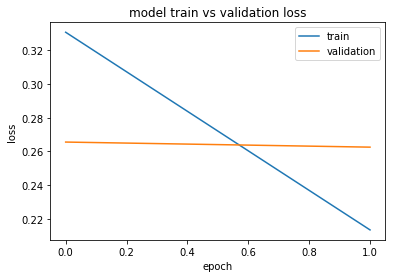

In [21]:
from matplotlib import pyplot

pyplot.plot(ep_loss)
pyplot.plot(ep_val_loss)
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Creating and reviewing these plots can help to inform you about possible new configurations to try in order to get better performance from your model.

Next, we will look at some examples. We will consider model skill on the train and validation sets in terms of loss that is minimized. You can use any metric that is meaningful on your problem.

#### The question is: what this graph means?

### 3. Underfit Example

An underfit model is one that is demonstrated to perform well on the training dataset and poor on the test dataset.

This can be diagnosed from a plot where the training loss is lower than the validation loss, and the validation loss has a trend that suggests further improvements are possible.

A small contrived example of an underfit LSTM model is provided below.

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array

Using TensorFlow backend.


In [23]:
# return training data
def get_train():
	seq = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((len(X), 1, 1))
	return X, y

In [24]:
# return validation data
def get_val():
	seq = [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((len(X), 1, 1))
	return X, y

In [25]:
# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mse', optimizer='adam')

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [27]:
# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=100, validation_data=(valX, valY), shuffle=False)

Train on 5 samples, validate on 5 samples
Epoch 1/100
5/5 [==============================] - 0s 94ms/step - loss: 0.1234 - val_loss: 0.7569
Epoch 2/100
5/5 [==============================] - 0s 753us/step - loss: 0.1218 - val_loss: 0.7513
Epoch 3/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1202 - val_loss: 0.7457
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1187 - val_loss: 0.7402
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1171 - val_loss: 0.7347
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1156 - val_loss: 0.7292
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1141 - val_loss: 0.7237
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1126 - val_loss: 0.7183
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 0.1111 - val_loss: 0.7130
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1096 - v

Epoch 85/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0359 - val_loss: 0.3954
Epoch 86/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0354 - val_loss: 0.3921
Epoch 87/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.3889
Epoch 88/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.3856
Epoch 89/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.3825
Epoch 90/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.3793
Epoch 91/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.3761
Epoch 92/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.3730
Epoch 93/100
5/5 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.3699
Epoch 94/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0311 - val_loss: 0.3668
Epoch 95/100
5/5 [==

Running this example produces a plot of train and validation loss showing the characteristic of an underfit model. In this case, performance may be improved by increasing the number of training epochs.

In this case, performance may be improved by increasing the number of training epochs.

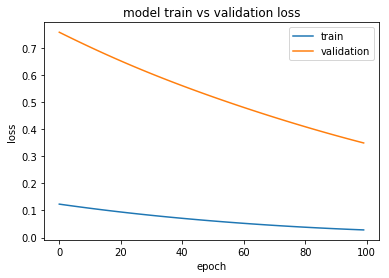

In [28]:
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Alternately, a model may be underfit if performance on the training set is better than the validation set and performance has leveled off. Below is an example of an

Below is an example of an an underfit model with insufficient memory cells.

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array

In [30]:
# return training data
def get_train():
	seq = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((5, 1, 1))
	return X, y

In [31]:
# return validation data
def get_val():
	seq = [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((len(X), 1, 1))
	return X, y

In [32]:
# define model
model = Sequential()
model.add(LSTM(1, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mae', optimizer='sgd')

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=300, validation_data=(valX, valY), shuffle=False)

Train on 5 samples, validate on 5 samples
Epoch 1/300
5/5 [==============================] - 0s 63ms/step - loss: 0.2971 - val_loss: 0.7806
Epoch 2/300
5/5 [==============================] - 0s 2ms/step - loss: 0.2870 - val_loss: 0.7706
Epoch 3/300
5/5 [==============================] - 0s 2ms/step - loss: 0.2770 - val_loss: 0.7605
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 0.2670 - val_loss: 0.7505
Epoch 5/300
5/5 [==============================] - 0s 2ms/step - loss: 0.2570 - val_loss: 0.7405
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - loss: 0.2470 - val_loss: 0.7304
Epoch 7/300
5/5 [==============================] - 0s 3ms/step - loss: 0.2370 - val_loss: 0.7204
Epoch 8/300
5/5 [==============================] - 0s 3ms/step - loss: 0.2269 - val_loss: 0.7103
Epoch 9/300
5/5 [==============================] - 0s 1ms/step - loss: 0.2169 - val_loss: 0.7003
Epoch 10/300
5/5 [==============================] - 0s 1ms/step - loss: 0.2069 - val

Epoch 85/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1179 - val_loss: 0.4902
Epoch 86/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1182 - val_loss: 0.4922
Epoch 87/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1179 - val_loss: 0.4902
Epoch 88/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1182 - val_loss: 0.4922
Epoch 89/300
5/5 [==============================] - 0s 1ms/step - loss: 0.1178 - val_loss: 0.4901
Epoch 90/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1182 - val_loss: 0.4921
Epoch 91/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1178 - val_loss: 0.4901
Epoch 92/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1182 - val_loss: 0.4921
Epoch 93/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1178 - val_loss: 0.4901
Epoch 94/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1182 - val_loss: 0.4920
Epoch 95/300
5/5 [==

Epoch 168/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.4906
Epoch 169/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1176 - val_loss: 0.4926
Epoch 170/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.4906
Epoch 171/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1176 - val_loss: 0.4926
Epoch 172/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1178 - val_loss: 0.4905
Epoch 173/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1176 - val_loss: 0.4925
Epoch 174/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1178 - val_loss: 0.4905
Epoch 175/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1176 - val_loss: 0.4925
Epoch 176/300
5/5 [==============================] - 0s 1ms/step - loss: 0.1178 - val_loss: 0.4905
Epoch 177/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1176 - val_loss: 0.4925
Epoch 178/

Epoch 251/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1174 - val_loss: 0.4910
Epoch 252/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1175 - val_loss: 0.4890
Epoch 253/300
5/5 [==============================] - 0s 5ms/step - loss: 0.1174 - val_loss: 0.4910
Epoch 254/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1174 - val_loss: 0.4890
Epoch 255/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1174 - val_loss: 0.4909
Epoch 256/300
5/5 [==============================] - 0s 1ms/step - loss: 0.1174 - val_loss: 0.4889
Epoch 257/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1174 - val_loss: 0.4909
Epoch 258/300
5/5 [==============================] - 0s 5ms/step - loss: 0.1174 - val_loss: 0.4889
Epoch 259/300
5/5 [==============================] - 0s 4ms/step - loss: 0.1174 - val_loss: 0.4909
Epoch 260/300
5/5 [==============================] - 0s 3ms/step - loss: 0.1174 - val_loss: 0.4888
Epoch 261/

Running this example shows the characteristic of an underfit model that appears under-provisioned.

In this case, performance may be improved by increasing the capacity of the model, such as the number of memory cells in a hidden layer or number of hidden layers.

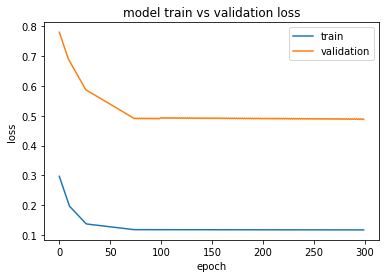

In [35]:
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### 4. Good Fit Example

A good fit is a case where the performance of the model is good on both the train and validation sets.

This can be diagnosed from a plot where the train and validation loss decrease and stabilize around the same point.

The small example below demonstrates an LSTM model with a good fit.

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array

In [37]:
# return training data
def get_train():
	seq = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((5, 1, 1))
	return X, y

In [38]:
# return validation data
def get_val():
	seq = [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((len(X), 1, 1))
	return X, y

In [39]:
# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mse', optimizer='adam')

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [42]:
# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=800, validation_data=(valX, valY), shuffle=False)

Train on 5 samples, validate on 5 samples
Epoch 1/800
5/5 [==============================] - 1s 146ms/step - loss: 0.1187 - val_loss: 0.7256
Epoch 2/800
5/5 [==============================] - 0s 1ms/step - loss: 0.1174 - val_loss: 0.7207
Epoch 3/800
5/5 [==============================] - 0s 4ms/step - loss: 0.1160 - val_loss: 0.7159
Epoch 4/800
5/5 [==============================] - 0s 3ms/step - loss: 0.1147 - val_loss: 0.7111
Epoch 5/800
5/5 [==============================] - 0s 3ms/step - loss: 0.1134 - val_loss: 0.7063
Epoch 6/800
5/5 [==============================] - 0s 2ms/step - loss: 0.1121 - val_loss: 0.7015
Epoch 7/800
5/5 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.6967
Epoch 8/800
5/5 [==============================] - 0s 4ms/step - loss: 0.1095 - val_loss: 0.6920
Epoch 9/800
5/5 [==============================] - 0s 2ms/step - loss: 0.1082 - val_loss: 0.6873
Epoch 10/800
5/5 [==============================] - 0s 2ms/step - loss: 0.1069 - va

5/5 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.3907
Epoch 85/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.3875
Epoch 86/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0374 - val_loss: 0.3843
Epoch 87/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.3811
Epoch 88/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.3779
Epoch 89/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.3748
Epoch 90/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.3717
Epoch 91/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0346 - val_loss: 0.3686
Epoch 92/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0341 - val_loss: 0.3655
Epoch 93/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0336 - val_loss: 0.3625
Epoch 94/800
5/5 [===============

Epoch 167/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.1990
Epoch 168/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.1976
Epoch 169/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.1963
Epoch 170/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.1950
Epoch 171/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.1937
Epoch 172/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.1924
Epoch 173/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.1912
Epoch 174/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0132 - val_loss: 0.1899
Epoch 175/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.1887
Epoch 176/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.1875
Epoch 177/

Epoch 250/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.1348
Epoch 251/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.1344
Epoch 252/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.1339
Epoch 253/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.1335
Epoch 254/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.1331
Epoch 255/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.1326
Epoch 256/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.1322
Epoch 257/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.1318
Epoch 258/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.1314
Epoch 259/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.1310
Epoch 260/

Epoch 333/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.1030
Epoch 334/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0084 - val_loss: 0.1027
Epoch 335/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.1023
Epoch 336/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.1019
Epoch 337/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.1016
Epoch 338/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.1012
Epoch 339/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.1008
Epoch 340/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.1005
Epoch 341/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.1001
Epoch 342/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0997
Epoch 343/

Epoch 416/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0733
Epoch 417/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0730
Epoch 418/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0726
Epoch 419/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0723
Epoch 420/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0720
Epoch 421/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0716
Epoch 422/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0713
Epoch 423/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0709
Epoch 424/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0706
Epoch 425/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0702
Epoch 426/

Epoch 499/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0464
Epoch 500/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0461
Epoch 501/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0458
Epoch 502/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0455
Epoch 503/800
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0452
Epoch 504/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0449
Epoch 505/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0446
Epoch 506/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0443
Epoch 507/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0440
Epoch 508/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0437
Epoch 509/

Epoch 582/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0246
Epoch 583/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0244
Epoch 584/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0242
Epoch 585/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0240
Epoch 586/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0237
Epoch 587/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0235
Epoch 588/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0233
Epoch 589/800
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0231
Epoch 590/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0229
Epoch 591/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0227
Epoch 592/

Epoch 665/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0100
Epoch 666/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0099
Epoch 667/800
5/5 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0098
Epoch 668/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 669/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0095
Epoch 670/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0094
Epoch 671/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0093
Epoch 672/800
5/5 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0091
Epoch 673/800
5/5 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0090
Epoch 674/800
5/5 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0089
Epoch 675

Epoch 746/800
5/5 [==============================] - 0s 5ms/step - loss: 5.5394e-04 - val_loss: 0.0027
Epoch 747/800
5/5 [==============================] - 0s 2ms/step - loss: 5.4760e-04 - val_loss: 0.0026
Epoch 748/800
5/5 [==============================] - 0s 4ms/step - loss: 5.4131e-04 - val_loss: 0.0026
Epoch 749/800
5/5 [==============================] - 0s 5ms/step - loss: 5.3509e-04 - val_loss: 0.0025
Epoch 750/800
5/5 [==============================] - 0s 5ms/step - loss: 5.2892e-04 - val_loss: 0.0025
Epoch 751/800
5/5 [==============================] - 0s 3ms/step - loss: 5.2281e-04 - val_loss: 0.0024
Epoch 752/800
5/5 [==============================] - 0s 6ms/step - loss: 5.1675e-04 - val_loss: 0.0024
Epoch 753/800
5/5 [==============================] - 0s 5ms/step - loss: 5.1076e-04 - val_loss: 0.0023
Epoch 754/800
5/5 [==============================] - 0s 3ms/step - loss: 5.0482e-04 - val_loss: 0.0023
Epoch 755/800
5/5 [==============================] - 0s 2ms/step - loss: 

Running the example creates a line plot showing the train and validation loss meeting.

Ideally, we would like to see model performance like this if possible, although this may not be possible on challenging problems with a lot of data.

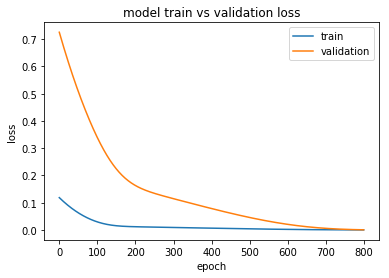

In [43]:
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### 5. Overfit Example

An overfit model is one where performance on the train set is good and continues to improve, whereas performance on the validation set improves to a point and then begins to degrade.

This can be diagnosed from a plot where the train loss slopes down and the validation loss slopes down, hits an inflection point, and starts to slope up again.

The example below demonstrates an overfit LSTM model.

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array

In [45]:
# return training data
def get_train():
	seq = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((5, 1, 1))
	return X, y

In [46]:
# return validation data
def get_val():
	seq = [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((len(X), 1, 1))
	return X, y

In [47]:
# define model
model = Sequential()
model.add(LSTM(10, input_shape=(1,1)))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mse', optimizer='adam')

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [49]:
# fit model
X,y = get_train()
valX, valY = get_val()
history = model.fit(X, y, epochs=1200, validation_data=(valX, valY), shuffle=False)

Train on 5 samples, validate on 5 samples
Epoch 1/1200
5/5 [==============================] - 1s 155ms/step - loss: 0.0980 - val_loss: 0.5646
Epoch 2/1200
5/5 [==============================] - 0s 738us/step - loss: 0.0968 - val_loss: 0.5601
Epoch 3/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0955 - val_loss: 0.5557
Epoch 4/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0943 - val_loss: 0.5513
Epoch 5/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0930 - val_loss: 0.5469
Epoch 6/1200
5/5 [==============================] - 0s 1ms/step - loss: 0.0918 - val_loss: 0.5425
Epoch 7/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0906 - val_loss: 0.5381
Epoch 8/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0893 - val_loss: 0.5337
Epoch 9/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0881 - val_loss: 0.5294
Epoch 10/1200
5/5 [==============================] - 0s 3ms/step - loss:

Epoch 84/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.2487
Epoch 85/1200
5/5 [==============================] - 0s 5ms/step - loss: 0.0230 - val_loss: 0.2458
Epoch 86/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.2429
Epoch 87/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.2400
Epoch 88/1200
5/5 [==============================] - 0s 9ms/step - loss: 0.0216 - val_loss: 0.2372
Epoch 89/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.2343
Epoch 90/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.2315
Epoch 91/1200
5/5 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.2288
Epoch 92/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0199 - val_loss: 0.2261
Epoch 93/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.2234
Epoch 94/1

Epoch 167/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.1052
Epoch 168/1200
5/5 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.1045
Epoch 169/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.1039
Epoch 170/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.1032
Epoch 171/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.1026
Epoch 172/1200
5/5 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.1019
Epoch 173/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.1013
Epoch 174/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.1007
Epoch 175/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.1001
Epoch 176/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0995


Epoch 249/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0729
Epoch 250/1200
5/5 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0726
Epoch 251/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0723
Epoch 252/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0720
Epoch 253/1200
5/5 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0717
Epoch 254/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0714
Epoch 255/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0711
Epoch 256/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0708
Epoch 257/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0706
Epoch 258/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0703


Epoch 331/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0494
Epoch 332/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0491
Epoch 333/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0488
Epoch 334/1200
5/5 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0486
Epoch 335/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0483
Epoch 336/1200
5/5 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0480
Epoch 337/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0477
Epoch 338/1200
5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0475
Epoch 339/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0472
Epoch 340/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0469


Epoch 413/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0286
Epoch 414/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0284
Epoch 415/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0281
Epoch 416/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0279
Epoch 417/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0277
Epoch 418/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0275
Epoch 419/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0272
Epoch 420/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0270
Epoch 421/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0268
Epoch 422/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0266


Epoch 495/1200
5/5 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0129
Epoch 496/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0128
Epoch 497/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 498/1200
5/5 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0125
Epoch 499/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0123
Epoch 500/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0122
Epoch 501/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0120
Epoch 502/1200
5/5 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0119
Epoch 503/1200
5/5 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0117
Epoch 504/1200
5/5 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0116


Epoch 577/1200
5/5 [==============================] - 0s 1ms/step - loss: 8.1802e-04 - val_loss: 0.0038
Epoch 578/1200
5/5 [==============================] - 0s 3ms/step - loss: 8.0955e-04 - val_loss: 0.0037
Epoch 579/1200
5/5 [==============================] - 0s 4ms/step - loss: 8.0115e-04 - val_loss: 0.0036
Epoch 580/1200
5/5 [==============================] - 0s 3ms/step - loss: 7.9281e-04 - val_loss: 0.0035
Epoch 581/1200
5/5 [==============================] - 0s 3ms/step - loss: 7.8453e-04 - val_loss: 0.0035
Epoch 582/1200
5/5 [==============================] - 0s 3ms/step - loss: 7.7631e-04 - val_loss: 0.0034
Epoch 583/1200
5/5 [==============================] - 0s 3ms/step - loss: 7.6816e-04 - val_loss: 0.0033
Epoch 584/1200
5/5 [==============================] - 0s 3ms/step - loss: 7.6007e-04 - val_loss: 0.0033
Epoch 585/1200
5/5 [==============================] - 0s 3ms/step - loss: 7.5204e-04 - val_loss: 0.0032
Epoch 586/1200
5/5 [==============================] - 0s 3ms/ste

Epoch 655/1200
5/5 [==============================] - 0s 3ms/step - loss: 3.3306e-04 - val_loss: 4.1566e-04
Epoch 656/1200
5/5 [==============================] - 0s 4ms/step - loss: 3.2890e-04 - val_loss: 3.9811e-04
Epoch 657/1200
5/5 [==============================] - 0s 4ms/step - loss: 3.2479e-04 - val_loss: 3.8107e-04
Epoch 658/1200
5/5 [==============================] - 0s 5ms/step - loss: 3.2071e-04 - val_loss: 3.6453e-04
Epoch 659/1200
5/5 [==============================] - 0s 4ms/step - loss: 3.1669e-04 - val_loss: 3.4847e-04
Epoch 660/1200
5/5 [==============================] - 0s 3ms/step - loss: 3.1270e-04 - val_loss: 3.3291e-04
Epoch 661/1200
5/5 [==============================] - 0s 2ms/step - loss: 3.0876e-04 - val_loss: 3.1783e-04
Epoch 662/1200
5/5 [==============================] - 0s 3ms/step - loss: 3.0486e-04 - val_loss: 3.0323e-04
Epoch 663/1200
5/5 [==============================] - 0s 3ms/step - loss: 3.0101e-04 - val_loss: 2.8910e-04
Epoch 664/1200
5/5 [========

Epoch 731/1200
5/5 [==============================] - 0s 5ms/step - loss: 1.2250e-04 - val_loss: 1.6730e-04
Epoch 732/1200
5/5 [==============================] - 0s 5ms/step - loss: 1.2088e-04 - val_loss: 1.7419e-04
Epoch 733/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.1927e-04 - val_loss: 1.8123e-04
Epoch 734/1200
5/5 [==============================] - 0s 2ms/step - loss: 1.1769e-04 - val_loss: 1.8843e-04
Epoch 735/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.1613e-04 - val_loss: 1.9578e-04
Epoch 736/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.1459e-04 - val_loss: 2.0327e-04
Epoch 737/1200
5/5 [==============================] - 0s 2ms/step - loss: 1.1307e-04 - val_loss: 2.1090e-04
Epoch 738/1200
5/5 [==============================] - 0s 4ms/step - loss: 1.1157e-04 - val_loss: 2.1868e-04
Epoch 739/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.1010e-04 - val_loss: 2.2659e-04
Epoch 740/1200
5/5 [========

Epoch 807/1200
5/5 [==============================] - 0s 3ms/step - loss: 4.7672e-05 - val_loss: 9.3281e-04
Epoch 808/1200
5/5 [==============================] - 0s 5ms/step - loss: 4.7166e-05 - val_loss: 9.4389e-04
Epoch 809/1200
5/5 [==============================] - 0s 4ms/step - loss: 4.6669e-05 - val_loss: 9.5497e-04
Epoch 810/1200
5/5 [==============================] - 0s 3ms/step - loss: 4.6180e-05 - val_loss: 9.6603e-04
Epoch 811/1200
5/5 [==============================] - 0s 4ms/step - loss: 4.5699e-05 - val_loss: 9.7707e-04
Epoch 812/1200
5/5 [==============================] - 0s 3ms/step - loss: 4.5227e-05 - val_loss: 9.8808e-04
Epoch 813/1200
5/5 [==============================] - 0s 5ms/step - loss: 4.4762e-05 - val_loss: 9.9907e-04
Epoch 814/1200
5/5 [==============================] - 0s 3ms/step - loss: 4.4305e-05 - val_loss: 0.0010
Epoch 815/1200
5/5 [==============================] - 0s 4ms/step - loss: 4.3856e-05 - val_loss: 0.0010
Epoch 816/1200
5/5 [================

Epoch 886/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.5846e-05 - val_loss: 0.0017
Epoch 887/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.5724e-05 - val_loss: 0.0017
Epoch 888/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.5605e-05 - val_loss: 0.0017
Epoch 889/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.5487e-05 - val_loss: 0.0017
Epoch 890/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.5372e-05 - val_loss: 0.0017
Epoch 891/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.5259e-05 - val_loss: 0.0017
Epoch 892/1200
5/5 [==============================] - 0s 2ms/step - loss: 2.5148e-05 - val_loss: 0.0017
Epoch 893/1200
5/5 [==============================] - 0s 2ms/step - loss: 2.5039e-05 - val_loss: 0.0017
Epoch 894/1200
5/5 [==============================] - 0s 2ms/step - loss: 2.4933e-05 - val_loss: 0.0017
Epoch 895/1200
5/5 [==============================] - 0s 3ms/ste

Epoch 965/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.0867e-05 - val_loss: 0.0021
Epoch 966/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.0841e-05 - val_loss: 0.0021
Epoch 967/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.0816e-05 - val_loss: 0.0021
Epoch 968/1200
5/5 [==============================] - 0s 5ms/step - loss: 2.0791e-05 - val_loss: 0.0021
Epoch 969/1200
5/5 [==============================] - 0s 4ms/step - loss: 2.0766e-05 - val_loss: 0.0021
Epoch 970/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.0742e-05 - val_loss: 0.0021
Epoch 971/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.0718e-05 - val_loss: 0.0021
Epoch 972/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.0695e-05 - val_loss: 0.0022
Epoch 973/1200
5/5 [==============================] - 0s 3ms/step - loss: 2.0672e-05 - val_loss: 0.0022
Epoch 974/1200
5/5 [==============================] - 0s 3ms/ste

Epoch 1044/1200
5/5 [==============================] - 0s 2ms/step - loss: 1.9769e-05 - val_loss: 0.0023
Epoch 1045/1200
5/5 [==============================] - 0s 2ms/step - loss: 1.9762e-05 - val_loss: 0.0023
Epoch 1046/1200
5/5 [==============================] - 0s 5ms/step - loss: 1.9755e-05 - val_loss: 0.0023
Epoch 1047/1200
5/5 [==============================] - 0s 4ms/step - loss: 1.9748e-05 - val_loss: 0.0023
Epoch 1048/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9742e-05 - val_loss: 0.0023
Epoch 1049/1200
5/5 [==============================] - 0s 2ms/step - loss: 1.9736e-05 - val_loss: 0.0023
Epoch 1050/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9729e-05 - val_loss: 0.0023
Epoch 1051/1200
5/5 [==============================] - 0s 5ms/step - loss: 1.9723e-05 - val_loss: 0.0023
Epoch 1052/1200
5/5 [==============================] - 0s 4ms/step - loss: 1.9717e-05 - val_loss: 0.0023
Epoch 1053/1200
5/5 [==============================] - 

Epoch 1122/1200
5/5 [==============================] - 0s 5ms/step - loss: 1.9403e-05 - val_loss: 0.0024
Epoch 1123/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9399e-05 - val_loss: 0.0024
Epoch 1124/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9396e-05 - val_loss: 0.0024
Epoch 1125/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9392e-05 - val_loss: 0.0024
Epoch 1126/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9389e-05 - val_loss: 0.0024
Epoch 1127/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9385e-05 - val_loss: 0.0024
Epoch 1128/1200
5/5 [==============================] - 0s 2ms/step - loss: 1.9382e-05 - val_loss: 0.0024
Epoch 1129/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9378e-05 - val_loss: 0.0024
Epoch 1130/1200
5/5 [==============================] - 0s 3ms/step - loss: 1.9375e-05 - val_loss: 0.0024
Epoch 1131/1200
5/5 [==============================] - 

Running this example creates a plot showing the characteristic inflection point in validation loss of an overfit model.

This may be a sign of too many training epochs.

In this case, the model training could be stopped at the inflection point. Alternately, the number of training examples could be increased.

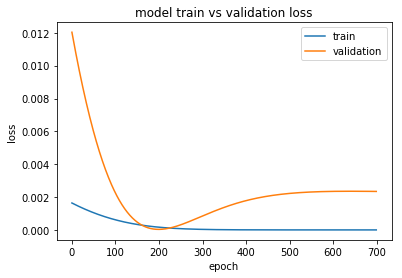

In [50]:
# plot train and validation loss
pyplot.plot(history.history['loss'][500:])
pyplot.plot(history.history['val_loss'][500:])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

### 6. Multiple Runs Example

LSTMs are stochastic, meaning that you will get a different diagnostic plot each run.

It can be useful to repeat the diagnostic run multiple times (e.g. 5, 10, or 30). The train and validation traces from each run can then be plotted to give a more robust idea of the behavior of the model over time.

The example below runs the same experiment a number of times before plotting the trace of train and validation loss for each run.

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
from pandas import DataFrame

In [52]:
# return training data
def get_train():
	seq = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((5, 1, 1))
	return X, y

In [53]:
# return validation data
def get_val():
	seq = [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
	seq = array(seq)
	X, y = seq[:, 0], seq[:, 1]
	X = X.reshape((len(X), 1, 1))
	return X, y

In [54]:
# collect data across multiple repeats
train = DataFrame()
val = DataFrame()
for i in range(5):
	# define model
	model = Sequential()
	model.add(LSTM(10, input_shape=(1,1)))
	model.add(Dense(1, activation='linear'))
	# compile model
	model.compile(loss='mse', optimizer='adam')
	X,y = get_train()
	valX, valY = get_val()
	# fit model
	history = model.fit(X, y, epochs=300, validation_data=(valX, valY), shuffle=False)
	# story history
	train[str(i)] = history.history['loss']
	val[str(i)] = history.history['val_loss']

Train on 5 samples, validate on 5 samples
Epoch 1/300
5/5 [==============================] - 1s 182ms/step - loss: 0.1114 - val_loss: 0.6575
Epoch 2/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1102 - val_loss: 0.6530
Epoch 3/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1089 - val_loss: 0.6486
Epoch 4/300
5/5 [==============================] - 0s 1ms/step - loss: 0.1076 - val_loss: 0.6442
Epoch 5/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1063 - val_loss: 0.6398
Epoch 6/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.6354
Epoch 7/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.6310
Epoch 8/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1026 - val_loss: 0.6266
Epoch 9/300
5/5 [==============================] - 0s 744us/step - loss: 0.1014 - val_loss: 0.6223
Epoch 10/300
5/5 [==============================] - 0s 2ms/step - loss: 0.1002 - 

Epoch 85/300
5/5 [==============================] - 0s 800us/step - loss: 0.0343 - val_loss: 0.3432
Epoch 86/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.3401
Epoch 87/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.3371
Epoch 88/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.3341
Epoch 89/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.3311
Epoch 90/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.3281
Epoch 91/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.3251
Epoch 92/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.3222
Epoch 93/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.3193
Epoch 94/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.3163
Epoch 95/300
5/5 [

Epoch 168/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.1651
Epoch 169/300
5/5 [==============================] - 0s 794us/step - loss: 0.0121 - val_loss: 0.1639
Epoch 170/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.1628
Epoch 171/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.1617
Epoch 172/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.1606
Epoch 173/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.1595
Epoch 174/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.1584
Epoch 175/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.1574
Epoch 176/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0117 - val_loss: 0.1564
Epoch 177/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.1554
Epoch 17

Epoch 251/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.1130
Epoch 252/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.1127
Epoch 253/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.1123
Epoch 254/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.1119
Epoch 255/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.1116
Epoch 256/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.1112
Epoch 257/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.1108
Epoch 258/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.1105
Epoch 259/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.1101
Epoch 260/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.1098
Epoch 261/

Epoch 34/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.5269
Epoch 35/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0728 - val_loss: 0.5230
Epoch 36/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0718 - val_loss: 0.5192
Epoch 37/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - val_loss: 0.5154
Epoch 38/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.5116
Epoch 39/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0690 - val_loss: 0.5079
Epoch 40/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.5042
Epoch 41/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0672 - val_loss: 0.5005
Epoch 42/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0663 - val_loss: 0.4969
Epoch 43/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0654 - val_loss: 0.4932
Epoch 44/300
5/5 [==

Epoch 118/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.2767
Epoch 119/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.2744
Epoch 120/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.2722
Epoch 121/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.2701
Epoch 122/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.2679
Epoch 123/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.2658
Epoch 124/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0203 - val_loss: 0.2636
Epoch 125/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.2615
Epoch 126/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0198 - val_loss: 0.2595
Epoch 127/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.2574
Epoch 128/

Epoch 201/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.1583
Epoch 202/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.1575
Epoch 203/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.1568
Epoch 204/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.1561
Epoch 205/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.1554
Epoch 206/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.1547
Epoch 207/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.1540
Epoch 208/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.1533
Epoch 209/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.1527
Epoch 210/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.1520
Epoch 211/

Epoch 284/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.1174
Epoch 285/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.1170
Epoch 286/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.1166
Epoch 287/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.1162
Epoch 288/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.1158
Epoch 289/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.1154
Epoch 290/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.1150
Epoch 291/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.1146
Epoch 292/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.1142
Epoch 293/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.1138
Epoch 294/

5/5 [==============================] - 0s 6ms/step - loss: 0.0430 - val_loss: 0.4137
Epoch 68/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.4103
Epoch 69/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.4068
Epoch 70/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.4034
Epoch 71/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0402 - val_loss: 0.4000
Epoch 72/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0396 - val_loss: 0.3966
Epoch 73/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.3932
Epoch 74/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.3899
Epoch 75/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.3866
Epoch 76/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.3833
Epoch 77/300
5/5 [===============

Epoch 151/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.2057
Epoch 152/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.2043
Epoch 153/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.2030
Epoch 154/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.2016
Epoch 155/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.2003
Epoch 156/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.1990
Epoch 157/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.1978
Epoch 158/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.1965
Epoch 159/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.1953
Epoch 160/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.1941
Epoch 161/

Epoch 234/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - val_loss: 0.1435
Epoch 235/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.1431
Epoch 236/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.1427
Epoch 237/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.1422
Epoch 238/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.1418
Epoch 239/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.1414
Epoch 240/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.1410
Epoch 241/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.1406
Epoch 242/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.1401
Epoch 243/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.1397
Epoch 244/

Epoch 17/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0964 - val_loss: 0.6432
Epoch 18/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0950 - val_loss: 0.6378
Epoch 19/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0936 - val_loss: 0.6325
Epoch 20/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0922 - val_loss: 0.6272
Epoch 21/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0908 - val_loss: 0.6220
Epoch 22/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0895 - val_loss: 0.6167
Epoch 23/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0881 - val_loss: 0.6115
Epoch 24/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0868 - val_loss: 0.6064
Epoch 25/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0855 - val_loss: 0.6012
Epoch 26/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0842 - val_loss: 0.5961
Epoch 27/300
5/5 [==

Epoch 101/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0240 - val_loss: 0.2999
Epoch 102/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0236 - val_loss: 0.2971
Epoch 103/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.2943
Epoch 104/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.2915
Epoch 105/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.2888
Epoch 106/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.2861
Epoch 107/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.2835
Epoch 108/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0215 - val_loss: 0.2808
Epoch 109/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.2782
Epoch 110/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.2757
Epoch 111/

Epoch 184/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.1613
Epoch 185/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.1606
Epoch 186/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0122 - val_loss: 0.1598
Epoch 187/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0122 - val_loss: 0.1591
Epoch 188/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.1583
Epoch 189/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.1576
Epoch 190/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.1569
Epoch 191/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.1562
Epoch 192/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.1555
Epoch 193/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.1549
Epoch 194/

Epoch 267/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.1191
Epoch 268/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.1187
Epoch 269/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.1183
Epoch 270/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.1179
Epoch 271/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.1175
Epoch 272/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.1171
Epoch 273/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.1167
Epoch 274/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.1163
Epoch 275/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.1159
Epoch 276/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.1155
Epoch 277/

Epoch 50/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.3246
Epoch 51/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.3210
Epoch 52/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.3175
Epoch 53/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.3141
Epoch 54/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.3106
Epoch 55/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.3072
Epoch 56/300
5/5 [==============================] - 0s 780us/step - loss: 0.0355 - val_loss: 0.3038
Epoch 57/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.3004
Epoch 58/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.2971
Epoch 59/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.2938
Epoch 60/300
5/5 [

Epoch 134/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.1283
Epoch 135/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.1271
Epoch 136/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.1260
Epoch 137/300
5/5 [==============================] - 0s 778us/step - loss: 0.0091 - val_loss: 0.1248
Epoch 138/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.1238
Epoch 139/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0089 - val_loss: 0.1227
Epoch 140/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.1216
Epoch 141/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.1206
Epoch 142/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0087 - val_loss: 0.1196
Epoch 143/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.1186
Epoch 14

Epoch 217/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0794
Epoch 218/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0791
Epoch 219/300
5/5 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0787
Epoch 220/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0784
Epoch 221/300
5/5 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0781
Epoch 222/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0778
Epoch 223/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0775
Epoch 224/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0772
Epoch 225/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0769
Epoch 226/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0766
Epoch 227/

Epoch 300/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0560


In the resulting plot, we can see that the general trend of underfitting holds across 5 runs and is a stronger case for perhaps increasing the number of training epochs.

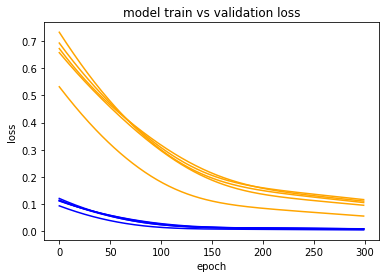

In [55]:
# plot train and validation loss across multiple runs
pyplot.plot(train, color='blue', label='train')
pyplot.plot(val, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.show()

### Summary

### 1. Reasons for underfitting and how to solve it

+ Not enough number of iteration (epoch) :arrow_right: add number of epoch

+ Model is not complex enough :arrow_right: add number of hidden neurons

### 2. Reasons for overfitting and how to solve it

+ Too many epochs :arrow_right: choose the best early stopping point
  
+ Model is too complex :arrow_right: reduce complexity